In [1]:
using Revise
using LazySets
using DifferentialEquations
using LazySets
using ProgressBars
using JLD2
using Flux
using LinearAlgebra
using Zygote
using ReverseDiff
using Plots
using Statistics
using Optimisers, ParameterSchedulers
using RobotDynamics
using RobotZoo
using Random
import RobotDynamics as RD

[ Info: Precompiling RobotZoo [74be38bb-dcc2-4b9e-baf3-d6373cd95f10]


In [2]:
using CUDA

# Check if GPU is available
if CUDA.functional()
    device!(2)
    CUDA.allowscalar(false)  # Disallow scalar operations on the GPU (optional)
else
    println("GPU is not available. Using CPU.")
end

In [2]:
X = Hyperrectangle(low = [0, 0, 0], high = [4,4, π])
U = Hyperrectangle(low = [-1, -1], high = [1,1])
X_unsafe = Hyperrectangle(low = [1.5, 0,0], high = [2.5,2, π])

Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([2.0, 1.0, 1.5707963267948966], [0.5, 1.0, 1.5707963267948966])

In [3]:
raw_training_data = load_object("car_seq_training_data.jld2")
raw_test_data = load_object("car_seq_test_data.jld2")

3×10001 Matrix{AbstractVector{Float64}}:
 [2.1394, 1.91681, 0.801756]  …  [1.66455, 1.99508, 1.00014]
 [0.290693, -0.214964]           [0.615991, 0.570133]
 [0.0]                           [0.0]

In [7]:
# TODO: find A B as with a batchsize dim on the last, using jacobian, Delta should be with the same size of x
include("affine_dynamics.jl")
using Flux
using ProgressBars
using JLD2

batchsize = 128
@show sum(raw_training_data[3,:]), size(raw_training_data[3,:])
state_dim = size(reduce(hcat,raw_training_data[1,:]))[1]

training_data = raw_training_data
test_data = raw_test_data

model = Chain(
    Dense(3 => 16, relu),   # activation function inside layer
    Dense(16 => 64, relu),   # activation function inside layer
    Dense(64 => 16, relu),   # activation function inside layer
    Dense(16 => 1)
)

# model = Chain(
#     Dense(4 => 16, sigmoid),   # activation function inside layer
#     Dense(16 => 64, sigmoid),   # activation function inside layer
#     Dense(64 => 16, sigmoid),   # activation function inside layer
#     Dense(16 => 1)
# )

# model = Chain(
#     Dense(4 => 16, tanh_fast),   # activation function inside layer
#     Dense(16 => 64, tanh_fast),   # activation function inside layer
#     Dense(64 => 16, tanh_fast),   # activation function inside layer
#     Dense(16 => 1)
# )

train_loader = Flux.DataLoader(training_data, batchsize=batchsize, shuffle=true)
test_loader = Flux.DataLoader(test_data, batchsize=batchsize, shuffle=true)

λ = 1
μ = 0.1
α = 0.0
use_pgd=true
use_adv = true
lr_lambda = 0.0001
mu = 0.9
V_lambda=0

lr_decay_rate = 0.2
lr_decay_epoch =4
total_epoch = 20

ini_lr = 0.01
optim = Flux.setup(Flux.Optimise.NADAM(ini_lr, (0.9, 0.999), 0.1), model)  # will store optimiser momentum, etc.
sched = ParameterSchedulers.Stateful(Step(ini_lr, lr_decay_rate, lr_decay_epoch)) # setup schedule of your choice

eps = 1e-3
dyn_model = RobotZoo.DubinsCar()
n,m = RD.dims(dyn_model)

training_losses = []
test_losses = []
least_loss = 1000
test_loss = 0
loss = 0
for epoch in ProgressBar(1:total_epoch)
    training_loss_epcoh = []
    test_loss_epcoh = []
    ∇l_lambda = 0
    ∇l_alpha = 0
    for item in train_loader
        ∇l_alpha = 0
        ∇l_lambda = 0
        x_batch = reduce(hcat,item[1,:])
        u_batch = reduce(hcat,item[2,:])
        y_init_batch = reduce(hcat,item[3,:])
        A = []
        B = []
        Δ = []
        for i in 1:size(x_batch, 2)
            z = RD.KnotPoint(x_batch[:, i],u_batch[:, i],0.0,1e-3 ) 
            ∇f = zeros(n, n + m)
            RD.jacobian!(RD.StaticReturn(), RD.ForwardAD(), dyn_model, ∇f, zeros(n), z)
            A_ = ∇f[:, 1:n]
            B_ = ∇f[:, n+1:end]
            Δ_ = RobotDynamics.dynamics(dyn_model, x_batch[:, i] .- eps, u_batch[:, i].-eps) - A_ * (x_batch[:, i].-eps) - B_ * (u_batch[:, i] .- eps)
            push!(A, A_)
            push!(B, B_)
            push!(Δ, Δ_)
        end
        A = cat(A..., dims=3)
        B = cat(B..., dims=3)
        Δ = cat(Δ..., dims=2)
        use_pgd && (u_batch = pgd_find_u_notce(model, A, x_batch, B, u_batch, U; α = α,Δ=Δ))
        if use_adv
            X_lcoal = [Hyperrectangle(x_batch[:, i], radius_hyperrectangle(X) ./ 20) for i=1:size(x_batch)[2]]
            x_batch = pgd_find_x_notce(model, A, x_batch, B, u_batch, X_lcoal; α = α,Δ=Δ)
        else
            x_batch = x_batch
        end

        use_pgd && (u_batch = pgd_find_u_notce(model, A, x_batch, B, u_batch, U; α = α,Δ=Δ))
        training_loss, grads = Flux.withgradient(model) do m 
            loss_naive_safeset(m, x_batch, y_init_batch) + λ .* loss_naive_fi(m, A, x_batch, B, u_batch,y_init_batch;use_pgd=false,use_adv = false, α=α,Δ=Δ) + μ .* loss_regularization(m, x_batch, y_init_batch)
        end
        # Update the parameters so as to reduce the objective,
        # according the chosen optimisation rule:
        Flux.update!(optim, model, grads[1])

        loss = loss_naive_safeset(model, x_batch, y_init_batch) + λ .* loss_naive_fi(model, A, x_batch, B, u_batch,y_init_batch;use_pgd=use_pgd,use_adv = false, α=α,Δ=Δ) + μ .* loss_regularization(model, x_batch, y_init_batch)
        push!(training_loss_epcoh, loss)  # logging, outside gradient context
        
    end
    for item in test_loader
        x_batch = reduce(hcat,item[1,:])
        u_batch = reduce(hcat,item[2,:])
        y_init_batch = reduce(hcat,item[3,:])
        A = []
        B = []
        Δ = []
        for i in 1:size(x_batch, 2)
            z = RD.KnotPoint(x_batch[:, i],u_batch[:, i],0.0,1e-3 ) 
            ∇f = zeros(n, n + m)
            RD.jacobian!(RD.StaticReturn(), RD.ForwardAD(), dyn_model, ∇f, zeros(n), z)
            A_ = ∇f[:, 1:n]
            B_ = ∇f[:, n+1:end]
            Δ_ = RobotDynamics.dynamics(dyn_model, x_batch[:, i] .- eps, u_batch[:, i].-eps) - A_ * (x_batch[:, i].-eps) - B_ * (u_batch[:, i] .- eps)
            push!(A, A_)
            push!(B, B_)
            push!(Δ, Δ_)
        end
        A = cat(A..., dims=3)
        B = cat(B..., dims=3)
        Δ = cat(Δ..., dims=2)

        test_loss =  loss_naive_safeset(model, x_batch, y_init_batch) + λ .* loss_naive_fi(model, A, x_batch, B, u_batch,y_init_batch;use_pgd=use_pgd,use_adv = false, α=α,Δ=Δ) + μ .* loss_regularization(model, x_batch, y_init_batch)
        push!(test_loss_epcoh, test_loss)
    end
    nextlr = ParameterSchedulers.next!(sched) # advance schedule
    Optimisers.adjust!(optim, nextlr) # update optimizer state, by default this changes the learning rate `eta`
    lr_lambda = lr_lambda * lr_decay_rate^(floor(epoch / lr_decay_epoch))
    @show epoch, loss, test_loss
    model_state = Flux.state(model)
    jldsave("car_adv20_model_1_0_0.1_pgd_relu_$epoch.jld2"; model_state)
    push!(training_losses, sum(training_loss_epcoh)) 
    push!(test_losses, sum(test_loss_epcoh))

end


(sum(raw_training_data[3, :]), size(raw_training_data[3, :])) = ([2.5e6], (4490000,))


0.0%┣                                              ┫ 0/20 [00:02<00:-43, -2s/it]
┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(3 => 16, relu)  # 64 parameters
│   summary(x) = "3×128 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


(epoch, loss, test_loss) = (1, 0.004457999215399697, 0.008754111781976038)


5.0%┣██                                      ┫ 1/20 [03:34:38<Inf:Inf, InfGs/it]


(epoch, loss, test_loss) = (2, 0.0045352203943739445, 0.0027486134805809865)


10.0%┣███▋                                ┫ 2/20 [06:16:50<113:02:58, 22.6ks/it]


(epoch, loss, test_loss) = (3, 0.0005384272028262268, 0.0029274569641504207)


15.0%┣█████▌                               ┫ 3/20 [09:11:16<78:05:45, 16.5ks/it]


(epoch, loss, test_loss) = (4, 0.0008145125870184383, 0.00478295030559233)


20.0%┣███████▍                             ┫ 4/20 [12:02:23<64:12:44, 14.4ks/it]


(epoch, loss, test_loss) = (5, 0.001290942884855604, 0.004127572520508326)


25.0%┣█████████▎                           ┫ 5/20 [14:50:26<55:39:09, 13.4ks/it]


(epoch, loss, test_loss) = (6, 0.0005012323810134213, 0.0019385678998571313)


30.0%┣███████████                          ┫ 6/20 [17:37:36<49:21:17, 12.7ks/it]


(epoch, loss, test_loss) = (7, 0.0008879941159856069, 0.0017635500855709228)


35.0%┣█████████████                        ┫ 7/20 [20:42:03<44:51:06, 12.4ks/it]


(epoch, loss, test_loss) = (8, 0.001337591362700942, 0.0036801435748395187)


40.0%┣██████████████▉                      ┫ 8/20 [23:53:00<40:56:34, 12.3ks/it]


(epoch, loss, test_loss) = (9, 0.0016689274066685146, 0.0019066233792381382)


45.0%┣████████████████▋                    ┫ 9/20 [26:42:36<36:43:34, 12.0ks/it]


(epoch, loss, test_loss) = (10, 1.8776555260881834e-5, 0.0032943576377008742)


50.0%┣██████████████████                  ┫ 10/20 [29:22:53<32:38:45, 11.8ks/it]


(epoch, loss, test_loss) = (11, 0.0013709432859345724, 0.002497215998212575)


55.0%┣███████████████████▉                ┫ 11/20 [32:14:55<29:01:26, 11.6ks/it]


(epoch, loss, test_loss) = (12, 0.0040661475875264355, 8.883145379510089e-5)


60.0%┣█████████████████████▋              ┫ 12/20 [35:01:07<25:28:05, 11.5ks/it]


(epoch, loss, test_loss) = (13, 0.001647996045704606, 0.0014808305104058762)


65.0%┣███████████████████████▍            ┫ 13/20 [37:18:33<21:45:49, 11.2ks/it]


(epoch, loss, test_loss) = (14, 0.002165996255952175, 0.0029863568953501646)


70.0%┣█████████████████████████▏          ┫ 14/20 [39:51:49<18:23:55, 11.0ks/it]


(epoch, loss, test_loss) = (15, 0.0027971612643864353, 0.0008512081164398264)


75.0%┣███████████████████████████         ┫ 15/20 [42:37:32<15:13:24, 11.0ks/it]


(epoch, loss, test_loss) = (16, 0.00039403167931867145, 0.0032530453054710725)


80.0%┣████████████████████████████▉       ┫ 16/20 [45:22:57<12:06:07, 10.9ks/it]


(epoch, loss, test_loss) = (17, 9.642525791818132e-5, 0.002031198119520181)


85.0%┣██████████████████████████████▋     ┫ 17/20 [48:18:57<09:03:33, 10.9ks/it]


(epoch, loss, test_loss) = (18, 7.513949993080406e-5, 0.0016723902212551986)


90.0%┣████████████████████████████████▍   ┫ 18/20 [51:24:05<06:02:50, 10.9ks/it]


(epoch, loss, test_loss) = (19, 4.071845682836247e-5, 0.003600745450094169)


95.0%┣██████████████████████████████████▏ ┫ 19/20 [54:14:19<03:00:48, 10.8ks/it]


(epoch, loss, test_loss) = (20, 0.0014981105940953502, 0.0009802720561346938)


100.0%┣██████████████████████████████████████┫ 20/20 [57:02:58<00:00, 10.8ks/it]
100.0%┣██████████████████████████████████████┫ 20/20 [57:02:58<00:00, 10.8ks/it]


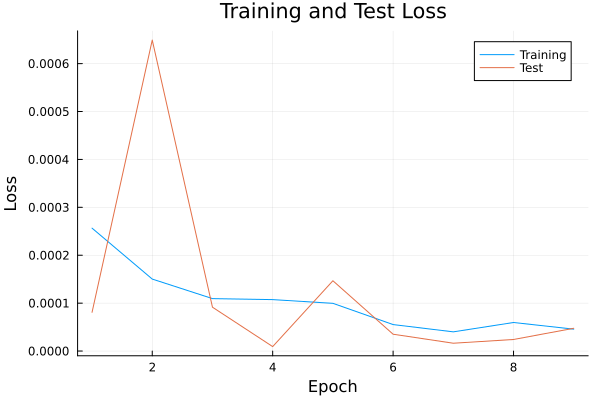

In [5]:
using Plots

function plot_loss(train_loss::Vector, test_loss::Vector; xlabel="Epoch", ylabel="Loss", title="Training and Test Loss")
    plot(train_loss ./ (size(training_data[3,:] / batchsize)), label="Training", xlabel=xlabel, ylabel=ylabel, title=title)
    plot!(test_loss ./ (size(test_data[3,:] / batchsize)), label="Test")
end

plot_loss(training_losses, test_losses)